In [ ]:
# pip install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client pandas torch transformers sentencepiece textblob matplotlib seaborn emoji

In [6]:
import pandas as pd
import os
from googleapiclient.discovery import build
import time
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import emoji
from openai import OpenAI

In [7]:
# YouTube API Key
api_key = 'YOUR_API_KEY'

# Channel ID
channel_id = 'UCmXpqtgnZMtHc6bnAczlJaQ'

# Playlist com os vídeos desejados
upload_playlist_id = f'UU{channel_id[2:]}'

# OpenAI API Key
client = OpenAI(
    api_key='YOUR_API_KEY'
)

In [40]:
# Starts YouTube API
youtube = build("youtube", "v3", developerKey=api_key)

# Functions

# Functions to get videos and comments
def get_videos_and_comments(playlist_id, max_videos=50):
    all_data = []  # List to save video data and comments
    next_page_token = None  # Token for page control

    while True:
        # Request videos from a playlist
        request = youtube.playlistItems().list(
            part="snippet",
            playlistId=playlist_id,
            maxResults=max_videos,
            pageToken=next_page_token
        )
        response = request.execute()

        for item in response["items"]:
            video_id = item["snippet"]["resourceId"]["videoId"]
            title = item["snippet"]["title"]

            # Collect comments from videos
            comments = get_video_comments(video_id)

            for comment in comments:
                all_data.append({
                    "video_id": video_id,
                    "title": title,
                    "author": comment["author"],
                    "comment": comment["comment"]
                })

        next_page_token = response.get("nextPageToken")
        if not next_page_token:
            break

    return pd.DataFrame(all_data)


def get_video_comments(video_id):
    comments = []
    next_page_token = None

    while True:
        try:
            request = youtube.commentThreads().list(
                part="snippet",
                videoId=video_id,
                maxResults=100,
                pageToken=next_page_token
            )
            response = request.execute()

            for item in response.get("items", []):
                comment = item["snippet"]["topLevelComment"]["snippet"]
                comments.append({
                    "author": comment["authorDisplayName"],
                    "comment": comment["textDisplay"]
                })

            next_page_token = response.get("nextPageToken")
            if not next_page_token:
                break
        except Exception as e:
            print(f"Erro ao coletar comentários do vídeo {video_id}: {e}")
            break

    return comments


def load_sentiment_model(model_name):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    return tokenizer, model


# Function to analyze sentiment using * BERT *
def analyze_sentiment_bert(text):
    if isinstance(text, str):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
            scores = F.softmax(outputs.logits, dim=1).numpy()[0]

        sentiment_labels = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]
        return sentiment_labels[scores.argmax()]
    return "Neutral"


# Function to analyze sentiment using * XLM-RoBERTa *
def analyze_sentiment_roberta(text):
    if isinstance(text, str):
        # Transform emoji into text
        text = emoji.demojize(text)

        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
            scores = F.softmax(outputs.logits, dim=1).numpy()[0]

        sentiment_labels = ["Negative", "Neutral", "Positive"]
        return sentiment_labels[scores.argmax()]
    return "Neutral"



# Function to send a comment to ChatGPT and get sentiment
def get_openai_sentiment_single(comment):
    prompt = f"""
    Classify the following comment into one of the categories:
    - Very Positive
    - Positive
    - Neutral
    - Negative
    - Very Negative

    Respond only with one of these categories, without explanations or additional formatting.

    Comment: "{comment}"
    """

    try:
        completion = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are an assistant specialized in sentiment analysis."},
                {"role": "user", "content": prompt}
            ]
        )

        response = completion.choices[0].message.content.strip()
        return response

    except Exception as e:
        print(f"Error processing comment: {e}")
        return "Neutral"  # Fallback to avoid errors

### Getting data from YouTube

In [9]:
# Collect video data and comments
df_comments = get_videos_and_comments(upload_playlist_id)

print(f"Total de vídeos/comentários coletados: {len(df_comments)}")
df_comments.head(10)

Total de vídeos/comentários coletados: 146


,video_id,title,author,comment
0,vX-CC3l7aZY,Análise de Dados usando Python PySpark no Data...,@matheusluiz6,"Excelente didática, professor. Muito obrigado ..."
1,vX-CC3l7aZY,Análise de Dados usando Python PySpark no Data...,@cleberalmeida9974,"Professor, tudo bem ? cara, assisti e me ajudo..."
2,vX-CC3l7aZY,Análise de Dados usando Python PySpark no Data...,@OceanAlves23,"Muito bom! Olá, tem como enviar os arquivos qu..."
3,vX-CC3l7aZY,Análise de Dados usando Python PySpark no Data...,@alexandremcosta,"Muito boa a explicação, me ajudou com os vídeo..."
4,vX-CC3l7aZY,Análise de Dados usando Python PySpark no Data...,@joyvitecoski3787,"Cara, não para de fazer vídeos, pfvr! Sua didá..."
5,vX-CC3l7aZY,Análise de Dados usando Python PySpark no Data...,@EduardoNascimentodeSouzaSepulv,Ótima aula! Meus parabéns no compartilhamento ...
6,vX-CC3l7aZY,Análise de Dados usando Python PySpark no Data...,@LeoAugSv,"Ótima aula, como sempre. Continue com essas au..."
7,vX-CC3l7aZY,Análise de Dados usando Python PySpark no Data...,@alessoclass3929,Crack!!!
8,vX-CC3l7aZY,Análise de Dados usando Python PySpark no Data...,@SergioMediceGarcia,Conteudo top! Parabéns 👏👏
9,vX-CC3l7aZY,Análise de Dados usando Python PySpark no Data...,@brucefrigerio2257,"Iradíssimo, Renan!"


### Using BERT model to analyze sentiments

<ipython-input-14-a62bfeadb7ee>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_percentages_bert.index, y=sentiment_percentages_bert.values, palette="viridis")


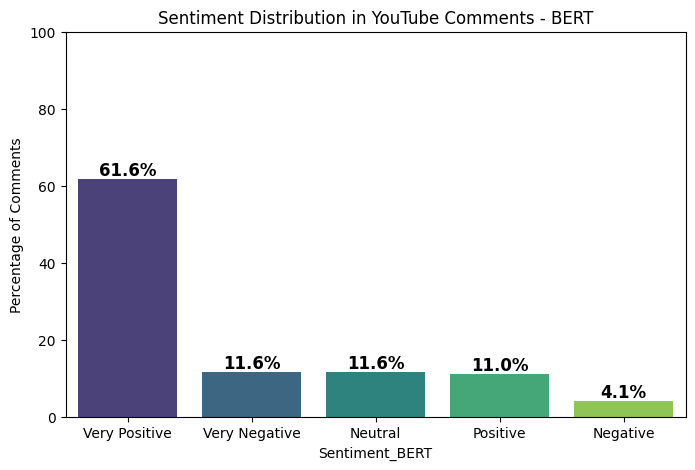

In [14]:
# Load the pre-trained BERT model for sentiment analysis
MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# Apply sentiment analysis using BERT
df_comments["sentiment_bert"] = df_comments["comment"].apply(analyze_sentiment_bert)

# Count the sentiment distribution
sentiment_counts_bert = df_comments["sentiment_bert"].value_counts()
sentiment_percentages_bert = (sentiment_counts_bert / sentiment_counts_bert.sum()) * 100

# Create a bar chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=sentiment_percentages_bert.index, y=sentiment_percentages_bert.values, palette="viridis")

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Sentiment Distribution in YouTube Comments - BERT")
plt.xlabel("Sentiment_BERT")
plt.ylabel("Percentage of Comments")
plt.ylim(0, 100)
plt.show()

### Using RoBERTa model to analyze sentiments

<ipython-input-15-3496167fecf5>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_percentages_roberta.index, y=sentiment_percentages_roberta.values, palette="viridis")


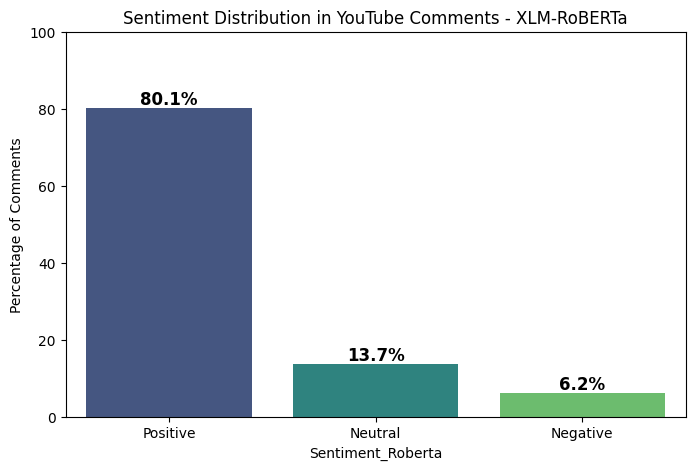

In [15]:
# Load the pre-trained XLM-RoBERTa model for sentiment analysis
MODEL_NAME = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# Apply sentiment analysis using XLM-RoBERTa
df_comments["sentiment_roberta"] = df_comments["comment"].apply(analyze_sentiment_roberta)

# Count the sentiment distribution
sentiment_counts_roberta = df_comments["sentiment_roberta"].value_counts()
sentiment_percentages_roberta = (sentiment_counts_roberta / sentiment_counts_roberta.sum()) * 100

# Create a bar chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=sentiment_percentages_roberta.index, y=sentiment_percentages_roberta.values, palette="viridis")

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Sentiment Distribution in YouTube Comments - XLM-RoBERTa")
plt.xlabel("Sentiment_Roberta")
plt.ylabel("Percentage of Comments")
plt.ylim(0, 100)
plt.show()

### Using OpenAI API to analyze sentiments

<ipython-input-12-afb7a121bd6c>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_percentages_openai.index, y=sentiment_percentages_openai.values, palette="viridis")


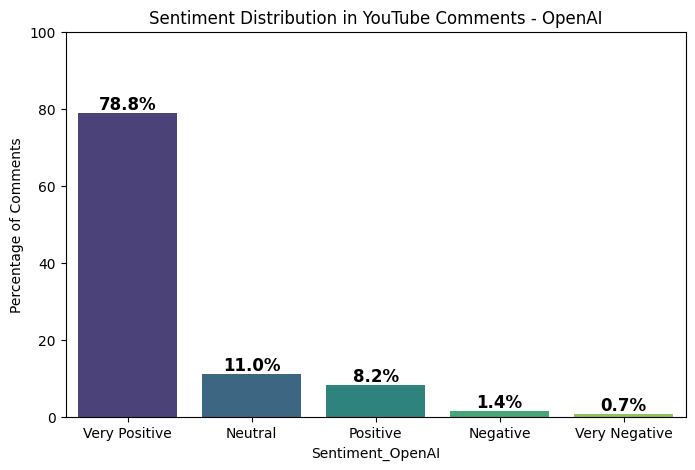

Sentiment analysis completed using OpenAI API!


In [12]:
# Get sentiment analisys created by ChatGPT

# OBS: chatgpt doesn't seem to respond well to many replies at once, so I'll send one at time to avoid inconsistencies

openai_sentiment = []

for comment in df_comments['comment']:
  single_sentiment = get_openai_sentiment_single(comment)
  openai_sentiment.append(single_sentiment)
  time.sleep(0.3) # little break

# Transform result list into a column
df_comments['sentiment_openai'] = openai_sentiment

# Count the sentiment distribution
sentiment_counts_openai = df_comments["sentiment_openai"].value_counts()
sentiment_percentages_openai = (sentiment_counts_openai / sentiment_counts_openai.sum()) * 100

# Create a bar chart
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=sentiment_percentages_openai.index, y=sentiment_percentages_openai.values, palette="viridis")

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Sentiment Distribution in YouTube Comments - OpenAI")
plt.xlabel("Sentiment_OpenAI")
plt.ylabel("Percentage of Comments")
plt.ylim(0, 100)
plt.show()


print("Sentiment analysis completed using OpenAI API!")

<ipython-input-17-fe1798ac2a96>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sentiment_percentages_openai.index, y=sentiment_percentages_openai.values, palette="viridis")


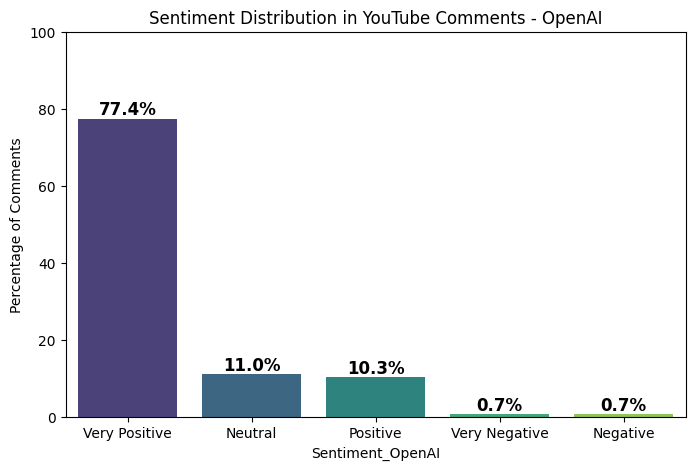

Sentiment analysis completed using OpenAI API!


In [17]:
# I decided to run the chatGPT again, and got a different answer, with shows a little bit of inconsistencies

### Comparing answers between models

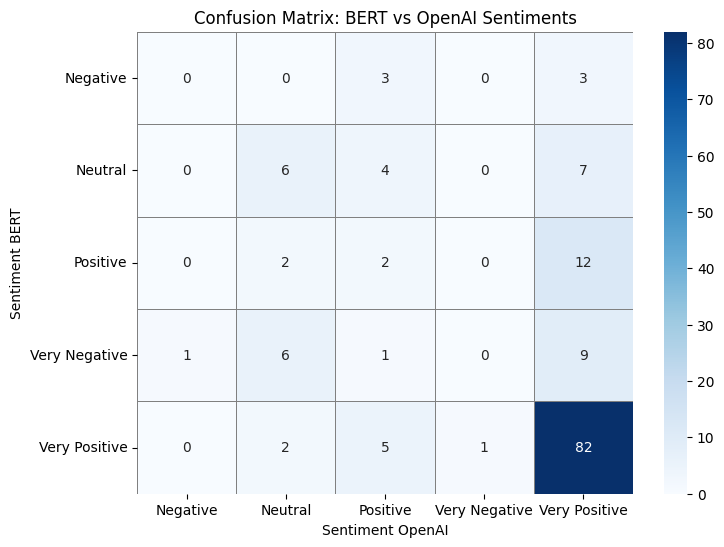

In [43]:
# Create confusion matrix to compare BERT and OpenAI sentiments
conf_matrix = pd.crosstab(df_comments["sentiment_bert"], df_comments["sentiment_openai"])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", linewidths=0.5, linecolor='gray')
plt.title("Confusion Matrix: BERT vs OpenAI Sentiments")
plt.xlabel("Sentiment OpenAI")
plt.ylabel("Sentiment BERT")
plt.show()


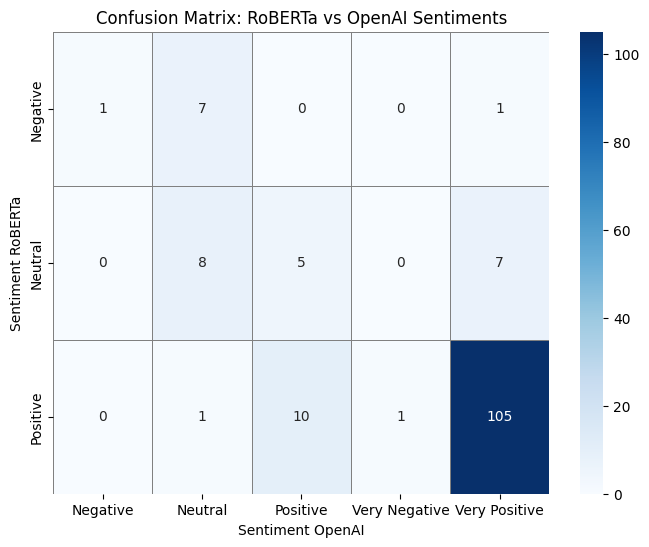

In [42]:
# Create confusion matrix to compare RoBERTa and OpenAI sentiments
conf_matrix = pd.crosstab(df_comments["sentiment_roberta"], df_comments["sentiment_openai"])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", linewidths=0.5, linecolor='gray')
plt.title("Confusion Matrix: RoBERTa vs OpenAI Sentiments")
plt.xlabel("Sentiment OpenAI")
plt.ylabel("Sentiment RoBERTa")
plt.show()


In [41]:
# Here we can analyze the difference in opinions of some comments where the BERT model classified as negative and the other models as Positive / Very Positive

pd.set_option('display.max_colwidth', None)
df_comments[(df_comments['sentiment_bert'] == 'Negative') & ((df_comments['sentiment_roberta'] != 'Negative') | (df_comments['sentiment_openai'] != 'Negative'))]

,video_id,title,author,comment,sentiment_bert,sentiment_roberta,sentiment_openai
30,QQlABnBQSro,Como fazer uma Pipeline com ETL no Dataprep da Google Cloud Platform (GCP),@PromonTI,"Ótimo vídeo!<br><br>Porém para mim não aparece o botão &quot;Schedule&quot; sendo que possuo o plano Starter comprado, o qual deveria ter a funcionalidade de &quot;Schedule &amp; Orchestrate Data Pipelines&quot;. Sabe o que poderia ser?? <br><br>Obrigado, abs.",Negative,Positive,Positive
52,EoI3XwxCkfI,PySpark - Aula 03 - Union / Joins / When - Otherwise / Collect,@josepaulo9054,"Renan,\r<br>\r<br> Boa noite, \r<br>\r<br> Queria tirar uma duvida a respeito do Collect.\r<br> A duvida.\r<br> Eu tenho dois dataframe.\r<br> Primeiro de Nota Fiscal, onde tenho 50K Linhas e usando o Filter, \r<br> quero trazer apenas as NF de São Paulo, o retorno será de 10K de notas fiscais.\r<br> Na sequencia quero colocar o nº de cada uma dessas 10.000 NF em uma collect.\r<br> Depois quando for gerar o dataframe de Itens de notas fiscais, quero trazer apenas os itens das NF que constam em uma lista gerada no for feito no collect e \r<br> vou fazer isso no Filter com In ListaCollectNfSaoPaulo e com isso vou trazer os itens de NF das 10.000 Nf do Dataframe de NF.\r<br> Faz algum sentido isso que falei e se dá para ser implementado.\r<br>\r<br>Parabens pelo seu canal, excelentes conteudos e principalmente por ser em Português, pois o idioma é uma tremenda barreira. \r<br>\r<br>Grato.",Negative,Neutral,Positive
72,MG-QBpEXvjg,PySpark - Aula 02 - Window Functions - Português - Hands On,@gabrielarruda9701,"Mano, seus vídeos são demais, continue gravando!",Negative,Positive,Very Positive
91,ycZZs4371us,PySpark - Aula 01 - Fundamentos - Tutorial em Português na Prática,@GuilhermeHenrique-sk1ww,"Muito obrigado pelo conteúdo mano! Mesmo sabendo programação, entrar em dados com pyhton é bem desafiador, a sintaxe é muito diferente e o pyspark é outra diversidade dentro desse mar de letras kkkkkkkk",Negative,Positive,Positive
108,ycZZs4371us,PySpark - Aula 01 - Fundamentos - Tutorial em Português na Prática,@adrianolisboa729,Amigão... vc é muito PHERA!!! Didático pra caramba,Negative,Positive,Very Positive
129,ycZZs4371us,PySpark - Aula 01 - Fundamentos - Tutorial em Português na Prática,@brunclopes,"Bacana demais suas aulas, Renan! Ótima didática. Por favor, continue com o ótimo conteúdo!",Negative,Positive,Very Positive


In [32]:
# Adjust values for a fair comparison between models

df_mapped = df_comments.copy()
df_mapped["sentiment_openai"] = df_mapped["sentiment_openai"].replace({"Very Positive": "Positive", "Very Negative": "Negative"})
df_mapped["sentiment_bert"] = df_mapped["sentiment_bert"].replace({"Very Positive": "Positive", "Very Negative": "Negative"})

In [39]:
# Comparing agreement rate between BERT and OpenAI

bertvsopenai = (df_mapped["sentiment_bert"] == df_mapped["sentiment_openai"]).mean() * 100
robertavsopenai = (df_mapped["sentiment_roberta"] == df_mapped["sentiment_openai"]).mean() * 100
bertvsroberta = (df_mapped["sentiment_roberta"] == df_mapped["sentiment_bert"]).mean() * 100

print(f"Os modelos BERT e RoBERTa concordam em {bertvsroberta:.2f}% dos casos.")
print(f"Os modelos BERT e OpenAI concordam em {bertvsopenai:.2f}% dos casos.")
print(f"Os modelos RoBERTa e OpenAI concordam em {robertavsopenai:.2f}% dos casos.")

Os modelos BERT e RoBERTa concordam em 71.92% dos casos.
Os modelos BERT e OpenAI concordam em 73.97% dos casos.
Os modelos RoBERTa e OpenAI concordam em 84.93% dos casos.
